# 导入相关模组

In [2]:
import yaml
import pcse
#  import sys
import os
import pickle
import copy
import numpy as np
import pandas as pd

from Wofost_opt_NWLP import my_crop_dict, my_agro, ModelRerunner
from pcse.fileinput import YAMLCropDataProvider, CABOFileReader, YAMLAgroManagementReader
from pcse.exceptions import PCSEError, PartitioningError
from pcse.util import WOFOST80SiteDataProvider, WOFOST71SiteDataProvider
from pcse.base import ParameterProvider
from pcse.fileinput import YAMLAgroManagementReader
from pcse.fileinput import ExcelWeatherDataProvider
from pcse.models import Wofost80_NWLP_FD_beta as Wofost80_NWLP_FD
from pcse.models import Wofost72_WLP_FD
from tqdm import tqdm

In [3]:
from datetime import datetime, timedelta
# 日期转儒略日
def d2jd(date: str, format="%Y-%m-%d", mode=1) -> int:

    dt = datetime.strptime(date, format)
    tt = dt.timetuple()
    # return tt.tm_year * 1000 + tt.tm_yday
    if mode == 1:
        return tt.tm_yday
    else:
        return tt.tm_year * 1000 + tt.tm_yday

# 儒略日转日期
def jd2d(jd: str, format="%Y-%m-%d") -> str:
    dt = datetime.strptime(jd, "%Y%j").date()
    return dt.strftime(format)

In [4]:
data_dir = os.path.join(os.getcwd(), "data")

In [5]:
def isdir_demo(dir_path):
    if not os.path.isdir(dir_path):
        try:
            os.mkdir(dir_path)
        except FileNotFoundError:
            os.makedirs(dir_path)

## 2.1 读取作物参数

In [6]:
cropfile = os.path.join(data_dir, 'npkfile', 'wofost_npk.crop')
cropd = CABOFileReader(cropfile)


## 2.2 土壤参数

In [7]:
soilfile = os.path.join(data_dir, 'soil', 'ec3_copy1.soil')
soild = CABOFileReader(soilfile)

## 2.3 站点数据

In [8]:
# NAVAILI       Amount of N available in the pool at initialization of the system [kg/ha] 0-32
# sited = WOFOST71SiteDataProvider(WAV=18)
sited = WOFOST80SiteDataProvider(WAV=18, NAVAILI=20.5, PAVAILI=50.0, KAVAILI=250.0)

## 2.4 合并数据

In [9]:
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

## 2.5 读取管理文件

In [10]:
with open("./data/npkfile/wofost_npk2022.agro", 'r') as f:
    yaml_agro_2022 = f.read()
with open("./data/npkfile/wofost_npk2021.agro", 'r') as f:
    yaml_agro_2021 = f.read()

## 2.6 气象数据

In [11]:
weatherfile = os.path.join(data_dir, 'meteo', 'WOFOSTYL.xlsx')
wdp = ExcelWeatherDataProvider(weatherfile)

# 3 模型运行

In [12]:
def overwrite_para(params, param_dict):
    params.clear_override()
    params.set_override("TSUMEM", 125.0)
    params.set_override("TSUM1", 1300)
    params.set_override("TSUM2", 720)
    crop_dict = my_crop_dict()

    for parname, value in param_dict.items():

        tmp_name = parname.split("00")
        if len(tmp_name) == 2:
            var_name, idx1 = tmp_name[0], int(tmp_name[1])
            if var_name == "FLTB" or var_name == "FOTB":
                crop_dict[var_name][idx1] = value
                crop_dict['FSTB'][idx1] = 1 - crop_dict['FLTB'][idx1] - crop_dict['FOTB'][idx1]
                params.set_override(var_name, crop_dict[var_name])
                params.set_override("FSTB", crop_dict["FSTB"])
                # print("%s: %s" % (var_name, parameters[var_name]))
            else:
                crop_dict[var_name][idx1] = value
                params.set_override(var_name, crop_dict[var_name])

        else:
            var_name = parname
            params.set_override(var_name, value)
    return params

In [37]:
# 管理文件数据
agro = my_agro(yaml_agro_2022, 180)

In [38]:
param_dict = {
    "TSUMEM": 93.2, "TSUM1": 1199.21, "TSUM2": 794.35,
    'AMAXTB001': 81.7121888514895, 'CVS': 0.329121467457929, 'CVO': 0.9058005069724505,           
    'EFFTB001': 0.48336079258353787, 'EFFTB003': 0.6455378025518874, 'FLTB001': 0.6238628980908938, 
    'KDIFTB003': 0.7234994333878939, 'NCRIT_FR': 0.9110596892310302, 'NMAXSO': 0.015122114006625076, 
    'SLATB001': 0.0013528940745241608, 'SLATB003': 0.00140832568159012, 'SPAN': 49.30346137485921, 
    'TDWI': 30.99146290837611, 'TMNFTB003': 1.1870409185448094
    }

In [39]:
parameters = overwrite_para(params=parameters, param_dict=param_dict)

In [40]:
parameters['NAVAILI']

20.5

In [41]:
Wofost1 = Wofost80_NWLP_FD(parameters, wdp, agro)
Wofost1.run_till_terminate()

rr = Wofost1.get_summary_output()

In [42]:
print((rr[0]["DOE"] - rr[0]["DOS"]).days)
print((rr[0]["DOA"] - rr[0]["DOS"]).days)
print((rr[0]["DOM"] - rr[0]["DOS"]).days)

6
61
102


In [18]:
modelrerunner = ModelRerunner(parameters, wdp, agro)
result = modelrerunner(param_dict, flag=True)
print(result[1])

[{'DVS': 2.0, 'LAIMAX': 1.1930396219784034, 'TAGP': 10560.823915238785, 'TWSO': 7539.672380567814, 'TWLV': 860.621014889991, 'TWST': 2160.53051978098, 'TWRT': 449.98895166475586, 'CTRAT': 10.185043796750124, 'RD': 100.0, 'DOS': datetime.date(2021, 6, 12), 'DOE': datetime.date(2021, 6, 19), 'DOA': datetime.date(2021, 8, 12), 'DOM': datetime.date(2021, 9, 25), 'DOH': None, 'DOV': None, 'CEVST': 7.287803551659001, 'NuptakeTotal': 92.31283687575778, 'PuptakeTotal': 31.27646896048108, 'KuptakeTotal': 101.877682849833, 'NamountSO': 69.21890448343055, 'PamountSO': 25.277212917575774, 'KamountSO': 35.67771024645749}]


<AxesSubplot:xlabel='day'>

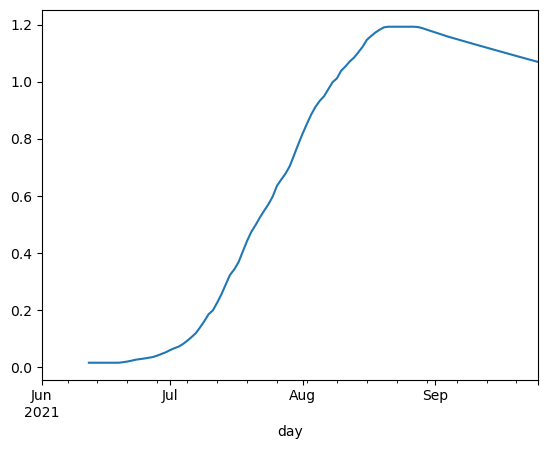

In [19]:
result[0].LAI.plot()

In [20]:

modelrerunner = Wofost80_NWLP_FD(parameters, wdp, agro)
modelrerunner.run_till_terminate()
print(modelrerunner.get_summary_output())

[{'DVS': 2.0, 'LAIMAX': 1.2584508321504673, 'TAGP': 6360.338504183919, 'TWSO': 3814.8931588043483, 'TWLV': 788.8388994011405, 'TWST': 1756.6064459784297, 'TWRT': 439.3782806340176, 'CTRAT': 9.19224538875005, 'RD': 82.60000000000005, 'DOS': datetime.date(2021, 6, 12), 'DOE': datetime.date(2021, 6, 20), 'DOA': datetime.date(2021, 7, 23), 'DOM': datetime.date(2021, 9, 1), 'DOH': None, 'DOV': None, 'CEVST': 4.424997119667298, 'NuptakeTotal': 74.44970383463152, 'PuptakeTotal': 23.709936373819737, 'KuptakeTotal': 92.06260926255689, 'NamountSO': 56.305191134714796, 'PamountSO': 19.12876331748382, 'KamountSO': 18.18940444841631}]


In [21]:
agro

[{datetime.date(2021, 6, 1): {'CropCalendar': {'crop_name': 'maize',
    'variety_name': 'Grain_maize_201',
    'crop_start_date': datetime.date(2021, 6, 12),
    'crop_start_type': 'sowing',
    'crop_end_date': None,
    'crop_end_type': 'maturity',
    'max_duration': 140},
   'TimedEvents': [{'event_signal': 'irrigate',
     'name': 'Timed irrigation events',
     'comment': 'All irrigation amounts in cm',
     'events_table': [{datetime.date(2021, 8, 2): {'amount': 0,
        'efficiency': 1.0}}]},
    {'event_signal': 'apply_npk',
     'name': 'Timed N/P/K application table',
     'comment': 'All fertilizer amounts in kg/ha',
     'events_table': [{datetime.date(2021, 6, 11): {'N_amount': 108.0,
        'P_amount': 90.0,
        'K_amount': 60.0,
        'N_recovery': 0.7,
        'P_recovery': 0.7,
        'K_recovery': 0.7}},
      {datetime.date(2021, 8, 2): {'N_amount': 72.0,
        'P_amount': 0.0,
        'K_amount': 0.0,
        'N_recovery': 0.7,
        'P_recovery': 0.

In [22]:
# 参数顺序
parameters_name = ["SLATB001", "SLATB003", "SPAN", "EFFTB003", "TMNFTB003", "CVO", "FLTB003", "TDWI", "CVS",
                       "NCRIT_FR", "EFFTB001", "KDIFTB003", "AMAXTB001"]

In [23]:
param_df = pd.read_csv(os.path.join(data_dir, "opt", "optNWLP", "opt_ZDN180_NWLP_result3.csv"), index_col=0)
param_df.sort_values(by=['rmse'], ascending=True, inplace=True)
# param_df = param_df[param_df['rmse'] < 0.31]

In [24]:
parameters_name = param_df.columns.to_list()
parameters_name = parameters_name[1: ]

In [25]:
def read_obs(file_path):
    obs_LAI = pd.read_csv(file_path)
    obs_LAI.index = pd.to_datetime(obs_LAI.day)
    obs_LAI.drop("day", axis=1, inplace=True)
    return obs_LAI

bio2022 = read_obs("F:\\paper_code\\MLlai\\data\\obs\\ZDN180Y2022_TAGP_OBS.csv")
bio2021 = read_obs("F:\\paper_code\\MLlai\\data\\obs\\ZDN180Y2021_TAGP_OBS.csv")
lai2021 = read_obs("F:\\paper_code\\MLlai\\data\\obs\\ZDN180Y2021_LAI_OBS.csv")
lai2022 = read_obs("F:\\paper_code\\MLlai\\data\\obs\\ZDN180Y2022_LAI_OBS.csv")
# sm2021 = read_obs("F:\\paper_code\\MLlai\\data\\obs\\ZDN180Y2021_SM_OBS.csv")
# sm2022 = read_obs("F:\\paper_code\\MLlai\\data\\obs\\ZDN180Y2022_SM_OBS.csv")


In [26]:
sited = WOFOST80SiteDataProvider(WAV=18, NAVAILI=20.5, PAVAILI=50.0, KAVAILI=250.0)
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

In [177]:
# 管理文件数据
## ZD idx = 1, 20.5 60
rows, _ = param_df.shape
df_dict = dict()
for nn in [180]:
    agro = my_agro(yaml_agro_2021, nn)
    modelrerunner = None
    modelrerunner = ModelRerunner(parameters, wdp, agro)
    twso_list = list()
    for i in tqdm([30]):
        p_value = dict()
        for each in parameters_name:
            p_value[each] = param_df.iloc[i][each]
        result = modelrerunner(p_value, flag=True)
        # if result[1][0]['TWSO'] > 8000:
        twso_list.append([i, result[1][0]['TWSO']])
    df1 = pd.DataFrame(twso_list, columns=["id", "TWSO"])
    df1.set_index("id", inplace=True)
    df_dict[str(nn)] = df1
    # print(result[0])
# print(modelrerunner.summary[0])

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


In [178]:
df_dict["180"]

,TWSO
id,
30,8919.618625


<AxesSubplot:xlabel='day'>

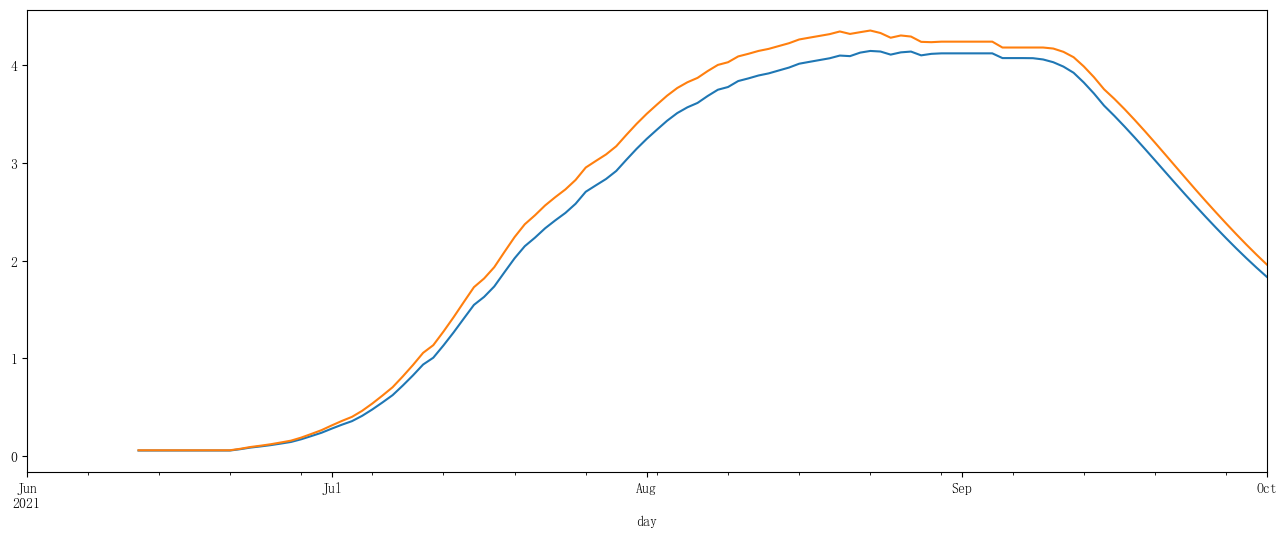

In [179]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(figsize=(16,6))
result[0].LAI.plot(ax=axes)
df2.LAI.plot(ax=axes)

In [180]:
df2

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,...,KAVAIL,Ndemand,RNuptake,Pdemand,RPuptake,Kdemand,RKuptake,NamountSO,PamountSO,KamountSO
day,,,,,,,,,,,,,,,,,,,,,
2021-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335000,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.345402,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.311917,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.296869,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-27,1.912241,2.379709,18745.616515,9217.141496,3422.588542,6105.886477,2027.219213,0.054559,100.0,0.285056,...,144.165101,32.723565,0.0,13.066185,0.0,0.0,0.0,102.275221,38.279632,43.736021
2021-09-28,1.933516,2.269679,18772.248003,9243.772984,3422.588542,6105.886477,2027.219213,0.121599,100.0,0.286994,...,144.165101,32.903681,0.0,12.956805,0.0,0.0,0.0,103.396849,38.737610,44.892703
2021-09-29,1.955612,2.162723,18840.210782,9311.735763,3422.588542,6105.886477,2027.219213,0.100329,100.0,0.284148,...,144.165101,32.988157,0.0,12.811640,0.0,0.0,0.0,104.406314,39.149791,45.949697


In [167]:
df2 = result[0]

In [158]:
df1

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,...,KAVAIL,Ndemand,RNuptake,Pdemand,RPuptake,Kdemand,RKuptake,NamountSO,PamountSO,KamountSO
day,,,,,,,,,,,,,,,,,,,,,
2021-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335000,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.345402,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.311917,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.296869,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-27,1.912241,2.379709,18745.616515,9217.141496,3422.588542,6105.886477,2027.219213,0.054559,100.0,0.285056,...,144.165101,32.723565,0.0,13.066185,0.0,0.0,0.0,102.275221,38.279632,43.736021
2021-09-28,1.933516,2.269679,18772.248003,9243.772984,3422.588542,6105.886477,2027.219213,0.121599,100.0,0.286994,...,144.165101,32.903681,0.0,12.956805,0.0,0.0,0.0,103.396849,38.737610,44.892703
2021-09-29,1.955612,2.162723,18840.210782,9311.735763,3422.588542,6105.886477,2027.219213,0.100329,100.0,0.284148,...,144.165101,32.988157,0.0,12.811640,0.0,0.0,0.0,104.406314,39.149791,45.949697


In [29]:
(result[1][0]["DOM"] - result[1][0]["DOS"]).days

111

In [30]:
result[1][0]["DOM"]

datetime.date(2021, 10, 1)

In [231]:
df_model = result[0]
em_date = "2021-06-12"
doy1 = d2jd(em_date)
dap = list()
for each in df_model.index:
    date_tuple = each.timetuple()
    doy2 = date_tuple.tm_yday
    dap.append(doy2 - doy1)
df_model['doy'] = dap
df_model = df_model[df_model.doy > -1]

In [232]:
tmp_df = df2.copy()
df_model.loc[:, "LAI_G"] = tmp_df.LAI*np.random.normal(1, 0.08, tmp_df.shape[0])
df_model.loc[:, "SM_G"] = tmp_df.SM*np.random.normal(1, 0.05, tmp_df.shape[0])

C:\Users\Dongh\AppData\Local\Temp\ipykernel_30968\1491514743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, "LAI_G"] = tmp_df.LAI*np.random.normal(1, 0.08, tmp_df.shape[0])
C:\Users\Dongh\AppData\Local\Temp\ipykernel_30968\1491514743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.loc[:, "SM_G"] = tmp_df.SM*np.random.normal(1, 0.05, tmp_df.shape[0])


In [233]:
# df_model.LAI.plot()


In [234]:
lai_tagp = df_model[["doy", "LAI", "TAGP", "SM", "SM_G", "LAI_G"]]

In [235]:
concat1 = pd.concat([lai_tagp, bio2021, lai2021], axis=1)


In [236]:
concat1

,doy,LAI,TAGP,SM,SM_G,LAI_G,TAGP_OBS,LAI_OBS
day,,,,,,,,
2021-06-12,0,0.060107,40.525542,0.230010,0.198841,0.062254,NaN,NaN
2021-06-13,1,0.060107,40.525542,0.223805,0.227594,0.060964,NaN,NaN
2021-06-14,2,0.060107,40.525542,0.218721,0.213790,0.064463,NaN,NaN
2021-06-15,3,0.060107,40.525542,0.382866,0.375832,0.063518,NaN,NaN
2021-06-16,4,0.060107,40.525542,0.335000,0.341169,0.058326,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-09-27,107,2.228668,18259.152242,0.288174,0.255186,2.366932,NaN,NaN
2021-09-28,108,2.124478,18276.873020,0.290134,0.320368,2.139906,NaN,NaN
2021-09-29,109,2.024008,18330.704866,0.287283,0.296573,1.973947,NaN,NaN


In [237]:
savePath = "./data/LAI/2021N180_4.csv"
remove = True
if remove:
    concat1.to_csv(savePath)
else:
    if os.path.isfile(savePath):
        print("该文件已存在，请检查路径")
    else:
        concat1.to_csv(savePath)

In [238]:
# 一致性分析
def cal_d(df_sim, df_obs):
    frac = np.sum((df_sim - df_obs)**2)
    divid = np.sum((np.abs(df_sim - df_sim.mean()) + np.abs(df_obs - df_obs.mean()))**2)
    return 1 - frac / divid

In [239]:
import matplotlib.pyplot as plt
import matplotlib
font_options = {'family': 'serif', 'serif': 'Simsun',}
plt.rc('font', **font_options)
matplotlib.rcParams.update({'font.family': 'sans', 'mathtext.fontset': 'stix', 'text.usetex': False})
plt.rcParams['font.sans-serif']=['Simsun'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
font_dict={'family' : 'Times New Roman', 'size'   : 12}
def draw_demo(X, Y1, X2, Y2, rangeX, rangeY, path_save=None, param_name="", text=None):
    
    fig, ax = plt.subplots(figsize=(6, 4))
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
    ax.set_xlim(rangeX[0], rangeX[1])
    ax.set_ylim(rangeY[0], rangeY[1])
    # 去除边框
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.plot(X, Y1, 'k', label="模拟值")
    ax.scatter(X2, Y2, c='k', label="实测值")
    # label显示在右外侧
    ax.legend(fontsize=13, bbox_to_anchor=(1.05, 0.3), prop={'family':'Simsun', 'size': 12})
    # ax.legend(fontsize=13, loc='lower right', bbox_to_anchor=(1.05, 0.5), prop={'family':'Times New Roman'})
    # ax.legend(prop={'family':'Simsun', 'size': 12})

    # 设置x轴刻度 size设置字体大小，fontproperties设置字体样式
    xticks = ax.get_xticks()
    x_label = [f"{i:<.0f}" for i in xticks]
    ax.set_xticks(xticks, x_label, fontproperties = 'Times New Roman', size=12)
    # 设置y轴刻度的字体和大小
    yticks = ax.get_yticks()
    y_label = [f"{i:<.1f}" for i in yticks]
    ax.set_yticks(yticks, y_label, fontproperties = 'Times New Roman', size=12)
    # 设置y轴 16单位是像素  相当于word中的小四
    ax.set_ylabel(param_name, size=14, linespacing=1.25)
    ax.set_xlabel('播种后天数(d)\n$\mathrm{Day\quadafter\quadsowing(d)}$', size=14, linespacing=1.25)
    if text is None:
        pass
    else:
        ax.text(5, 0.8*rangeY[1], text, fontdict={'family':'Times New Roman', 'size': 12}, linespacing=1.25)
    if path_save is None:
        pass
    else:
        # 解决导出svg格式的时候，图片外侧显示不全的问题
        # fig.subplots_adjust(right=0.75)
        plt.savefig(path_save, format="svg", dpi=750, bbox_inches = 'tight')
    # plt.close(fig)

In [240]:
draw_data = pd.read_csv("./data/LAI/2021N180_4.csv", index_col=0)
df_obs1 = draw_data.copy()
df_obs1.dropna(inplace=True, how="all", subset=["TAGP_OBS", "LAI_OBS"], axis=0)

## LAI画图用

In [241]:
# LAI画图用
df_obs = df_obs1[["doy", "LAI_G"]]
df_obs = df_obs.replace(0, np.nan)
df_obs = df_obs.dropna(axis=0, how="any")
# 计算一致性
frac = np.sum((draw_data.LAI - df_obs.LAI_G)**2)
divid = np.sum((np.abs(draw_data.LAI - draw_data.LAI.mean()) +
               np.abs(df_obs.LAI_G - df_obs.LAI_G.mean()))**2)
d = 1 - frac / divid

# 计算RMSE
RMSE = (draw_data.LAI - df_obs.LAI_G)**2
RMSE = np.sqrt(np.mean(RMSE))
nRMSE = RMSE / np.mean(df_obs.LAI_G) * 100

In [242]:
nRMSE

9.659926348002289

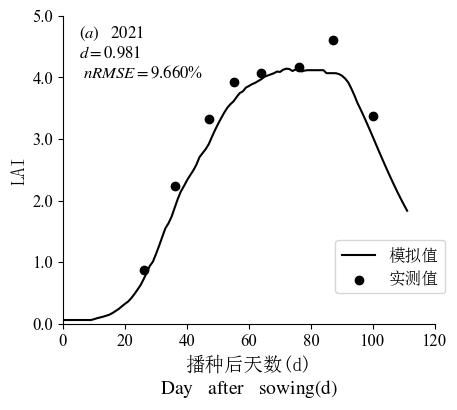

In [243]:
my_text = "$(a)\quad2021$\n$d = %.3f$ \n $nRMSE = %.3f$%%" % (d, nRMSE)
xlim = (0, 120)
ylim = (0, 5)
draw_demo(draw_data.doy, draw_data.LAI, df_obs.doy, df_obs.LAI_G, xlim, ylim,
          path_save="./img/opt/ZDN180LAI2021_0.svg", param_name="LAI", text=my_text)


## TAGP画图用

In [91]:
df_obs = draw_data[["doy", "TAGP_OBS"]]
df_obs = df_obs.dropna(axis=0, how="any")
df_obs = df_obs.replace(0, np.nan)
df_obs = df_obs.dropna(axis=0, how="any")
# 计算一致性
frac = np.sum((draw_data.TAGP - df_obs.TAGP_OBS)**2)
divid = np.sum((np.abs(draw_data.TAGP - draw_data.TAGP.mean()) +
               np.abs(df_obs.TAGP_OBS - df_obs.TAGP_OBS.mean()))**2)
d = 1 - frac / divid
# 计算RMSE
RMSE = (draw_data.TAGP - df_obs.TAGP_OBS)**2
RMSE = np.sqrt(np.mean(RMSE))
nRMSE = RMSE / np.mean(df_obs.TAGP_OBS) * 100


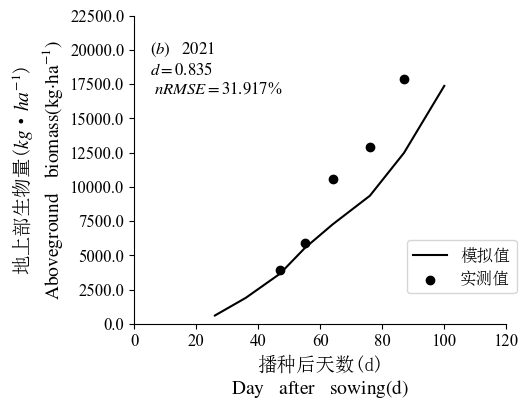

In [92]:
my_text = "$(b)\quad2021$\n$d = %.3f$ \n $nRMSE = %.3f$%%" % (d, nRMSE)
y_label = "地上部生物量($kg$·$ha^{-1}$)\n$\mathrm{Aboveground \quad biomass(kg·ha^{-1})}$"
xlim = (0, 120)
ylim = (0, 21000)
draw_demo(draw_data.doy, draw_data.TAGP, df_obs.doy, df_obs.TAGP_OBS, xlim, ylim, path_save="./img/opt/ZDN180TAGP2021_0.svg", param_name=y_label, text=my_text)

In [95]:
df_obs = draw_data[["doy", "SM_G"]]
df_obs = df_obs.dropna(axis=0, how="any")
df_obs = df_obs.replace(0, np.nan)
df_obs = df_obs.dropna(axis=0, how="any")
# 计算一致性
frac = np.sum((draw_data.SM - df_obs.SM_G)**2)
divid = np.sum((np.abs(draw_data.SM- draw_data.SM.mean()) +
               np.abs(df_obs.SM_G - df_obs.SM_G.mean()))**2)
d = 1 - frac / divid
# 计算RMSE
RMSE = (draw_data.SM - df_obs.SM_G)**2
RMSE = np.sqrt(np.mean(RMSE))
nRMSE = RMSE / np.mean(df_obs.SM_G) * 100

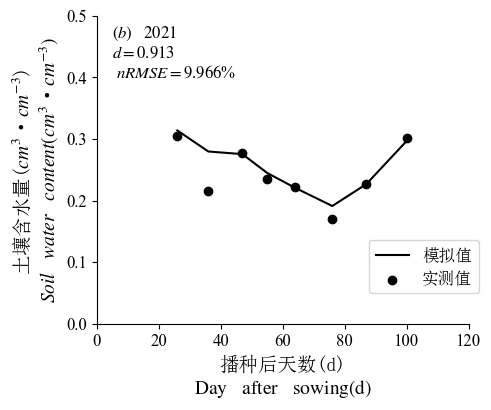

In [97]:
my_text = "$(b)\quad2021$\n$d = %.3f$ \n $nRMSE = %.3f$%%" % (d, nRMSE)
y_label = "土壤含水量($cm^3$·$cm^{-3}$) \n$Soil \quad water\quad content(cm^3$·$cm^{-3})$"
xlim = (0, 120)
ylim = (0, 0.5)
draw_demo(draw_data.doy, draw_data.SM, df_obs.doy, df_obs.SM_G, xlim, ylim,
          path_save="./img/opt/ZDN180SM2021_0.svg", param_name=y_label, text=my_text)


In [114]:
bio2021[["3"]]

,3
day,
2021-07-29,3912.0
2021-08-06,5891.4
2021-08-16,10603.0
2021-08-27,12909.0
2021-09-07,17898.0
2021-09-27,18928.8


In [90]:
yield_dict = {
        "ZDN180": {"0": [6796, 6274],
                   "90": [8288, 7397],
                   "180": [9607, 8426],
                   "270": [9573, 8346]
                   }
    }

In [1]:
import numpy as np

In [3]:
bounds = {
        "SLATB001": np.arange(0.0013, 0.0039, 0.0001),
        "SLATB003": np.arange(0.0005, 0.0015, 0.0001),
        "SPAN": np.arange(16.5, 50.5, 0.5),
        "EFFTB003": np.arange(0.225, 0.675, 0.001),
        "TMNFTB003": np.arange(0.5, 1.2, 0.1),
        "CVO": np.arange(0.4955, 0.9065, 0.0001),
        "FLTB001": np.arange(0.465, 0.775, 0.001),
        "TDWI": np.arange(25, 80, 1),
        "CVS": np.arange(0.329, 0.987, 0.001),
        "EFFTB001": np.arange(0.25, 0.75, 0.01),
        "KDIFTB003": np.arange(0.30, 0.90, 0.01),
        "NCRIT_FR": np.arange(0.50, 1.50, 0.01),
        "AMAXTB001": np.arange(35.0, 90.0, 2),
        "NMAXSO": np.arange(0.011, 0.033, 0.001),

    }

In [110]:
doa = 64
dom = 111


In [111]:
from scipy.stats import norm, uniform
like_doa = norm(loc=doa, scale=1.5)
like_dom = norm(loc=dom, scale=1.5)


In [115]:
like_doa.logpdf(60)

-4.879959196868392

In [128]:
like = uniform(loc=500, scale=500)

In [130]:
like.mean()

750.0